In [1]:
#'ATCNet', 'Deep4Net', 'DeepSleepNet', 'EEGConformer', 'EEGITNet', 'EEGInception', 'EEGInceptionERP', 
# 'EEGInceptionMI', 'EEGNetv1', 'EEGNetv4', 'EEGResNet', 'HybridNet', 'ShallowFBCSPNet', 'SleepStagerBlanco2020', 
# 'SleepStagerChambon2018', 'SleepStagerEldele2021', 'TCN', 'TIDNet', 'USleep'

# Authors: Lukas Gemein <l.gemein@gmail.com>
#
# License: BSD (3-clause)

import pandas as pd
import numpy as np
import mne
import os
import glob
from sklearn.metrics import f1_score
from skorch.dataset import ValidSplit
from braindecode import EEGClassifier
from braindecode.models import ATCNet
import torch
from skorch.dataset import ValidSplit
from skorch.callbacks import EpochScoring
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split


In [2]:

#"""" Code to Convert CSV data to MNE RawArray objects
# Step 1: Create a list of all filepaths to the CSV data
folder_path = './data_211/csv_file_format/'

file_paths = sorted(glob.glob(os.path.join(folder_path, '**', '211_*.csv')))

# Initialize an empty list to store the MNE RawArray objects & Descriptions
parts = []

descriptions_arr = []

#  - **Manually defined channel names**
ch_names = ['EEG.AF3', 'EEG.F7', 'EEG.F3', 'EEG.FC5',
                 'EEG.T7', 'EEG.P7', 'EEG.O1', 'EEG.O2',
                 'EEG.P8', 'EEG.T8', 'EEG.FC6', 'EEG.F4',
                 'EEG.F8', 'EEG.AF4']
    
sfreq = 128  # Replace with your actual sampling frequency
ch_types = ['eeg'] * len(ch_names)  # Assuming all channels are EEG
i = 0 # Counter for label

# Step 2: Convert CSV data to MNE RawArray objects
for path in file_paths:
    try:
        # Step 1: Read the CSV file using pandas - skip first 2 rows (header)
        data = pd.read_csv(path, skiprows=1)
   
        #print(data)

        if data.empty:
            print(f"Skipping empty file: {path}")
            continue

        data_array = data.values.T
        # Debugging output to check the shape of the data array
        print(f"Data array shape before selection: {data_array.shape}")
        print(data_array[0])

        # Ensure the data array has the correct number of channels
        if data_array.shape[0] < 64:
            raise ValueError(f"Data array has fewer than 64 channels: {data_array.shape}")
    
        # Manual selection of the EEG channels
        data_array = data_array[4:18]
        
        print(f"First Row after Row selection: {data_array[0]}")
        print(f"Last Row after Row selection: {data_array[-1]}")
        
        # Debugging output to check the shape of the data array after selection
        print(f"Data array shape after selection: {data_array.shape}")
    
        # Ensure the data array has the correct number of channels
        if data_array.shape[0] != len(ch_names):
            raise ValueError(f"Number of channels in data ({data_array.shape[0]}) does not match number of channel names ({len(ch_names)})")
    
        # Step 3: Create MNE Info object
        info = mne.create_info(ch_names=ch_names, sfreq=sfreq, ch_types=ch_types)

        if i < 101:
            label = 0 # Left movement
        else:
            label = 1 # Right movement
        i += 1

        # Step 4: Create RawArray object
        raw = mne.io.RawArray(data_array, info)
        
        # Create annotation based on the label
        annotations = mne.Annotations(onset=[2], duration=[8], description=[str(label)])
        raw.set_annotations(annotations)
    
        # Add to Descriptions Array
        descriptions_arr.append(pd.Series(label))    

        # Data preprocessing
        raw.filter(l_freq=4, h_freq=40, method='iir')  # Band-pass filter (4-40 Hz)
        raw.notch_filter(freqs=50)  # 50 Hz power line noise filtering
    
        # Step 5: Add to MNE RawArray array
        parts.append(raw)

# Step 3: Concatenate the MNE RawArray objects
    except pd.errors.EmptyDataError:
        print(f"Skipping empty file: {path}")
    except Exception as e:
        print(f"Error processing file {path}: {e}")

# Concatenate all Raw objects
if len(parts) > 0:
    combined_raw = mne.concatenate_raws(parts)
else:
    raise ValueError("No Raw objects to combine.")

if not parts:
    raise ValueError("No RawArray objects were created from the CSV files.")
#"""


Data array shape before selection: (68, 1634)
[1.73931175e+09 1.73931175e+09 1.73931175e+09 ... 1.73931177e+09
 1.73931177e+09 1.73931177e+09]
First Row after Row selection: [4154.230957 4156.922852 4148.205078 ... 4131.410156 4135.512695
 4127.820313]
Last Row after Row selection: [4397.820313 4400.256348 4397.05127  ... 4377.436035 4385.641113
 4380.512695]
Data array shape after selection: (14, 1634)
Creating RawArray with float64 data, n_channels=14, n_times=1634
    Range : 0 ... 1633 =      0.000 ...    12.758 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 40 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 4.00, 40.00 Hz: -6.02, -6.02 dB

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass,

C:\Users\nicho\AppData\Local\Temp\ipykernel_12708\2061369511.py:70: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw.set_annotations(annotations)
C:\Users\nicho\AppData\Local\Temp\ipykernel_12708\2061369511.py:77: RuntimeWarning: filter_length (845) is longer than the signal (726), distortion is likely. Reduce filter length or filter a longer signal.
  raw.notch_filter(freqs=50)  # 50 Hz power line noise filtering


Data array shape before selection: (68, 1527)
[1.73931397e+09 1.73931397e+09 1.73931397e+09 ... 1.73931399e+09
 1.73931399e+09 1.73931399e+09]
First Row after Row selection: [4149.358887 4155.641113 4153.461426 ... 4144.102539 4140.641113
 4138.205078]
Last Row after Row selection: [4403.974121 4408.333496 4401.410156 ... 4399.487305 4396.282227
 4394.871582]
Data array shape after selection: (14, 1527)
Creating RawArray with float64 data, n_channels=14, n_times=1527
    Range : 0 ... 1526 =      0.000 ...    11.922 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 40 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 4.00, 40.00 Hz: -6.02, -6.02 dB

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass,

C:\Users\nicho\AppData\Local\Temp\ipykernel_12708\2061369511.py:70: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw.set_annotations(annotations)
C:\Users\nicho\AppData\Local\Temp\ipykernel_12708\2061369511.py:77: RuntimeWarning: filter_length (845) is longer than the signal (314), distortion is likely. Reduce filter length or filter a longer signal.
  raw.notch_filter(freqs=50)  # 50 Hz power line noise filtering


Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 50.88 Hz)
- Filter length: 845 samples (6.602 s)

Skipping empty file: ./data_211/csv_file_format\left\211_r_EPOCX_266139_2025.02.11T16.22.36.06.00_intervalMarker.csv
Data array shape before selection: (68, 1574)
[1.73931477e+09 1.73931477e+09 1.73931477e+09 ... 1.73931478e+09
 1.73931478e+09 1.73931478e+09]
First Row after Row selection: [4131.794922 4135.641113 4134.358887 ... 4140.512695 4140.512695
 4136.666504]
Last Row after Row selection: [4507.179688 4518.974121 4520.128418 

In [3]:
#"""Preprocessing the data
#--------------------------------------------------------------------#
# Creating Epochs, Labels using MNE RawArray objects
#--------------------------------------------------------------------#

from sklearn.preprocessing import LabelEncoder


# Extract events from the annotations
events, event_id = mne.events_from_annotations(combined_raw)

# Define the epoching parameters
tmin = 0  # Start of the epoch relative to the event (in seconds)
tmax = 8  # End of the epoch relative to the event (in seconds) ********MANUAL SOLUTION


#show the combined_raw data
print(combined_raw)
# Create the Epochs object
epochs = mne.Epochs(combined_raw, events, event_id, tmin, tmax, 
                    reject=None, baseline=None, preload=True)

epoched_data = epochs.get_data(copy=True)
labels = epochs.events[:,-1]

label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(labels)
print(f"Labels: {labels}")
print(f"Labels shape: {labels.shape}")

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(epoched_data, labels, random_state=0)
print(f'X_train shape: {X_train.shape}')
print(f'X_test shape: {X_test.shape}')
print(f'y_train shape: {y_train.shape}')
print(f'y_test shape: {y_test.shape}')
#"""

Used Annotations descriptions: [np.str_('0'), np.str_('1')]


<RawArray | 14 x 312233 (2439.3 s), ~33.4 MiB, data loaded>
Not setting metadata
200 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 200 events and 1025 original time points ...
2 bad epochs dropped
Labels: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1]
Labels shape: (198,)
X_train shape: (148, 14, 1025)
X_test shape: (50, 14, 1025)
y_train shape: (148,)
y_test shape: (50,)


In [4]:
# Verify variables are correct values before training
#--------------------------------------------------------------------#

# Extract the number of channels and sampling frequency from the MNE Epochs object
n_channels = epochs.info['nchan']
sfreq = epochs.info['sfreq']
print(f"Channels, Freq: {n_channels, sfreq}")

# Determine the number of classes
n_classes = len(np.unique(labels))
print(f"Classes: {n_classes}")

# Calculate the expected number of time points based on your desired window length
input_window_seconds = tmax - tmin  # This will be 8 seconds
expected_n_times = int(input_window_seconds * sfreq) +1 # This will be 8 * 128 + 1 = 1025
print(f"Input window seconds: {input_window_seconds}")
print(f"Expected n_times: {expected_n_times}")


Channels, Freq: (14, 128.0)
Classes: 2
Input window seconds: 8
Expected n_times: 1025


In [5]:
#"""" Creating the Model, Train/Validate Model

def create_model(sfreq, n_channels, n_classes):
    model = ATCNet(
        sfreq=sfreq,
        n_chans=n_channels,
        n_outputs=n_classes,
        n_times=expected_n_times-1,
        input_window_seconds=8,
    )
    return model

model = create_model(sfreq, n_channels, n_classes)

# Define the EEGClassifier with ShallowFBCSPNet
net = EEGClassifier(
    module=model,  # Pass the class itself, not a string
    train_split=ValidSplit(0.12),
    optimizer=torch.optim.AdamW,  # Specify the optimizer
    lr=0.001,  # Specify the learning rate
    device='cuda' if torch.cuda.is_available() else 'cpu', # Use GPU if available
    callbacks=[('train_acc', EpochScoring(scoring='accuracy', on_train=True, name='train_acc')),
               ('train_f1', EpochScoring(scoring='f1', on_train=True, name='train_f1')),
                ('precision', EpochScoring(scoring='precision', on_train=True, name='train_precision')),
                ('recall', EpochScoring(scoring='recall', on_train=True, name='train_recall'))]  # Add the F1 score callback
)
print(f"Epoch Shape: {epoched_data.shape}")


net.fit(X_train, y_train, epochs=100)

print(net.module_)
#"""

c:\Users\nicho\anaconda3\envs\test\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +
c:\Users\nicho\anaconda3\envs\test\Lib\site-packages\torch\nn\modules\conv.py:549: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\native\Convolution.cpp:1037.)
  return F.conv2d(


Epoch Shape: (198, 14, 1025)
  epoch    train_acc    train_f1    train_loss    train_precision    train_recall    valid_acc    valid_loss     dur
-------  -----------  ----------  ------------  -----------------  --------------  -----------  ------------  ------
      1       0.4609      0.2737        0.7790             0.5000          0.1884       0.8333        0.6466  0.7766
      2       0.4609      0.3030        0.7790             0.5000          0.2174       0.2222        0.7535  0.5026
      3       0.4453      0.2198        0.7521             0.4348          0.1471       0.2222        0.8724  0.5837
      4       0.4922      0.3689        0.7273             0.5588          0.2754       0.2222        0.9683  0.5548
      5       0.6016      0.5714        0.6447             0.6939          0.4857       0.2222        1.0508  0.4376
      6       0.6641      0.6261        0.6148             0.7826          0.5217       0.2222        1.1319  0.3980
      7       0.6484      0.6400   

In [6]:
#""" Testing the Model

y_pred = net.predict(X_test)

# Calculate evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='macro')
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')

# Print the evaluation metrics
print(f"Test Accuracy: {accuracy:.4f}")
print(f"Test Precision: {precision:.4f}")
print(f"Test Recall: {recall:.4f}")
print(f"Test F1 Score: {f1:.4f}")
#"""

Test Accuracy: 0.9400
Test Precision: 0.9407
Test Recall: 0.9400
Test F1 Score: 0.9400


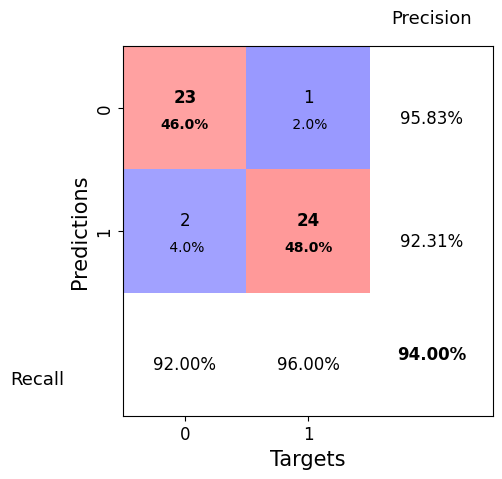

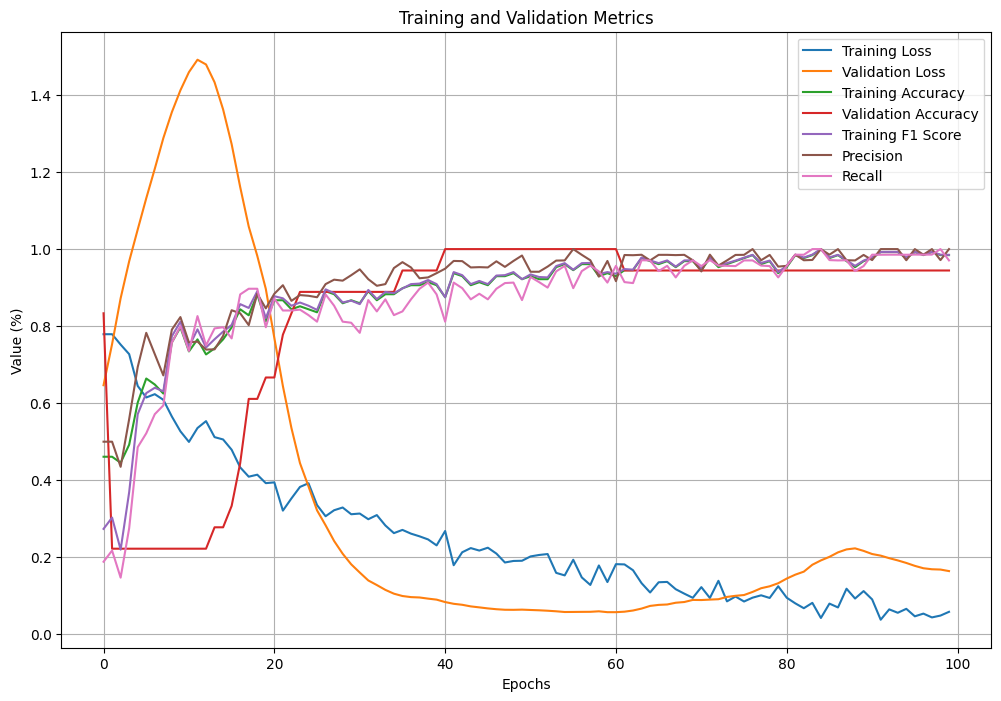

In [ ]:
#""" Figures and Plots of Data
# Plot the confusion matrix
from sklearn.metrics import confusion_matrix
from braindecode.visualization import plot_confusion_matrix
import matplotlib.pyplot as plt
from braindecode.visualization import compute_amplitude_gradients

# Manual labels dictionary for the confusion matrix
label_dict = {0: 'Left', 1: 'Right'}

# get the targets
y_true = np.array(y_test)
y_pred = np.array(y_pred)

# generating confusion matrix
confusion_mat = confusion_matrix(y_true, y_pred)

class_names = [label_dict[i] for i in range(len(label_dict))]

# plot the basic conf. matrix
plot_confusion_matrix(confusion_mat, class_names=label_dict)

#-----------------------------------------------------------------------------#
# Line plot of the training and validation metrics
#-----------------------------------------------------------------------------#

# Extract the values for the metrics
train_loss = net.history[:, 'train_loss']
valid_loss = net.history[:, 'valid_loss']
train_acc = net.history[:, 'train_acc']
valid_acc = net.history[:, 'valid_acc']
train_f1 = net.history[:, 'train_f1']
precision = net.history[:, 'train_precision']
recall = net.history[:, 'train_recall']

# Create the plot
epochs = np.arange(len(train_loss))

plt.figure(figsize=(12, 8))

plt.plot(epochs, train_loss, label='Training Loss')
plt.plot(epochs, valid_loss, label='Validation Loss')
plt.plot(epochs, train_acc, label='Training Accuracy')
plt.plot(epochs, valid_acc, label='Validation Accuracy')
plt.plot(epochs, train_f1, label='Training F1 Score')
plt.plot(epochs, precision, label='Precision')
plt.plot(epochs, recall, label='Recall')

plt.xlabel('Epochs')
plt.ylabel('Value (%)')
plt.title('Training and Validation Metrics')
plt.legend()
plt.grid(True, )
plt.show()

#-----------------------------------------------------------------------------#
# Plot the amplitude gradients
#-----------------------------------------------------------------------------#

#compute_amplitude_gradients(net.module_, X_test, net.batch_size)
#"""